In [1]:
%%writefile parallel_sklearn.py

# General imports
import numpy as np
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from mpi4py import MPI

from sklearn.model_selection import GridSearchCV

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Regression ############################################

# Metrics
from sklearn.metrics import r2_score

# Datasets
df = pd.read_csv('train.csv', sep=';').astype(str)
df = df.apply(lambda x: x.str.replace(',','.')).astype(float)
X = df[['Day', 'Month', 'Year','SunRad', 'Temp', 'TheorEff1', 'TheorEff2']]
y = df[['Eff1', 'Eff2']]
df = df.drop(index=df[df.Eff2 == 1.].index)
del X['TheorEff1']
del y['Eff1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train[X_train.columns] = MinMaxScaler().fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = MinMaxScaler().fit_transform(X_test[X_test.columns])

# Linear models
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

# Kernel models
from sklearn.svm import SVR
from sklearn.svm import NuSVR

# KNN
from sklearn.neighbors import KNeighborsRegressor

# Trees and ensembles
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

seed = 42

heavy_models = np.array([
    [DecisionTreeRegressor(random_state=seed), {
        'max_depth':[1, 3, 5],
        'min_samples_split':[2,3],
        'max_features':['auto', 'log2']}],

    [RandomForestRegressor(random_state=seed), {
        'n_estimators':[250, 500],
        'max_depth':[1, 3],
        'min_samples_split':[2,3],
        'max_features':['auto', 'log2']}],

    [AdaBoostRegressor(random_state=seed), {
        'n_estimators':[100, 250, 500],
        'loss':['linear', 'square',],
        'learning_rate':[1.0, 0.1, 1.5],
    }],
    [ElasticNet(random_state=seed), {
        'alpha':[1.0, 0.1, 1.5],
        'l1_ratio':[0.5, 0.25, 0.75],
    }],

    [Lasso(), {'alpha':[1.0, 0.1, 1.5]}],

    [Ridge(), {'alpha':[1.0, 0.1, 1.5]}],
])

ranked_models = np.array_split(heavy_models, size)
        
res = []
for item in ranked_models[rank]:
    model, parameters = item[0], item[1]
    reg = GridSearchCV(model, parameters)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    R2 = r2_score(y_test, y_pred)
    res.append([R2, reg.best_estimator_])

comp = comm.gather(res,root=0)

if rank == 0:
    sorted_models = []
    for item in comp:
        for element in item:
            sorted_models.append(element)
    sorted_models = sorted(sorted_models, reverse=True, key=lambda x: x[0])
    for item in sorted_models: print('{:<10.5} {}'.format(item[0], item[1]), end='\n')

Writing parallel_sklearn.py


In [2]:
!mpiexec -n 3 python parallel_sklearn.py

0.28763    Ridge()
0.001517   RandomForestRegressor(max_depth=3, n_estimators=500, random_state=42)
-0.014861  ElasticNet(random_state=42)
-0.014861  Lasso()
-0.12794   AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=42)
-0.36028   DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=42)


In [3]:
import time

t = []
for i in range(1, 10):
    t0 = time.time()
    !mpiexec -n {i} python parallel_sklearn.py
    t1 = time.time() - t0
    t.append(t1)

0.28763    Ridge()
0.001517   RandomForestRegressor(max_depth=3, n_estimators=500, random_state=42)
-0.014861  ElasticNet(random_state=42)
-0.014861  Lasso()
-0.12794   AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=42)
-0.36028   DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=42)
0.28763    Ridge()
0.001517   RandomForestRegressor(max_depth=3, n_estimators=500, random_state=42)
-0.014861  ElasticNet(random_state=42)
-0.014861  Lasso()
-0.12794   AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=42)
-0.36028   DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=42)
0.28763    Ridge()
0.001517   RandomForestRegressor(max_depth=3, n_estimators=500, random_state=42)
-0.014861  ElasticNet(random_state=42)
-0.014861  Lasso()
-0.12794   AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=42)
-0.36028   DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=42)
0.28763    Ridge()
0.0015

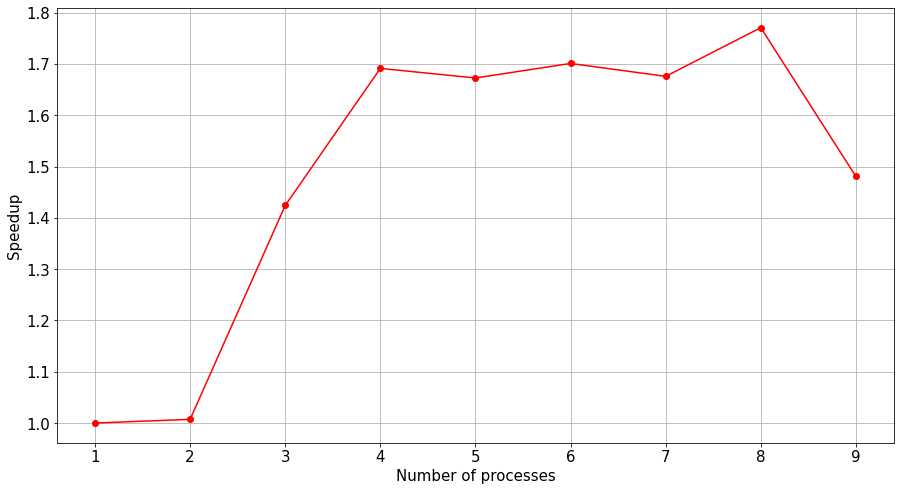

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.grid()
plt.yticks(fontsize=15)
plt.xticks(range(1, 10), fontsize=15)
plt.xlabel('Number of processes', fontsize=15)
plt.ylabel('Speedup', fontsize=15)
plt.plot(range(1, 10), [t[0]/i for i in t], '-o', color='r');